## Configuring the workspace
Assicurarsi di aver installato tutti le librerie necessarie per eseguire gli script all'interno del notebook

In [144]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import boxcox
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

# Creo la cartella data per salvare i dataset
if not os.path.exists("data"):
    os.makedirs("data")

In [145]:
# Test ADF
def test_ADF(series):
    result = adfuller(series)
    print(f'Statistica del test ADF: {result[0]}')
    print(f'P-value: {result[1]}')
    print('Critical Values:')
    for thres, adf_stat in result[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

    if result[1] < 0.05:
        print("La serie è stazionaria")
    else:
        print("La serie non è stazionaria")

# Serie temporale di produzione elettrica
Questo dataset è stato preso da [Kaggle](https://www.kaggle.com/datasets/shenba/time-series-datasets?select=Electric_Production.csv).  
Non ha una descrizione particolare, si tratta di valori di produzione elettrica misurata per ogni mese dal 1985 fino al 2018.

In [146]:
name_file="data/Electric_Production.csv"
if not os.path.exists(name_file):
    # Download the dataset
    !kaggle datasets download -d shenba/time-series-datasets -p data
    !unzip data/time-series-datasets.zip -d data

In [147]:
df_data = pd.read_csv(name_file)

# Rinominiamo le colonne per comodità
df_data.rename(columns={"DATE": "date", "IPG2211A2N": "value"}, inplace=True)
# Convertiamo la colonna date in formato datetime
df_data["date"] = pd.to_datetime(df_data["date"])

df_data.head()

,date,value
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [148]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    397 non-null    datetime64[ns]
 1   value   397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


# Controllo valori mancanti

In [149]:
print(f"Intervallo temporale della serie: da {df_data['date'].min()} fino a {df_data['date'].max()}")

Intervallo temporale della serie: da 1985-01-01 00:00:00 fino a 2018-01-01 00:00:00


In [150]:
# Creo un dataframe che contenga tutti i mesi dell'intervallo temporale
df = pd.DataFrame(index=pd.date_range(start=df_data['date'].min(), end=df_data['date'].max(), freq='MS'))

# Aggiungo l'indice temporale al dataset
df_data.set_index(pd.DatetimeIndex(df_data['date']),inplace=True)

# Unisco i due dataset
df = df.merge(df_data, how='left', left_index=True, right_index=True)

# Non ci sono valori mancanti
df.isna().sum()

date     0
value    0
dtype: int64

<Axes: >

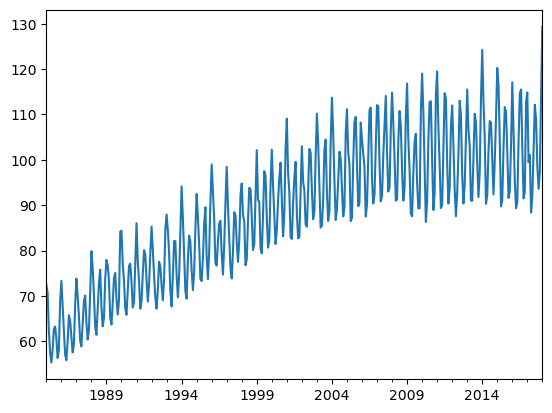

In [151]:
# Visualizzo la serie temporale
df["value"].plot()

# Analisi serie temporale

Text(0.5, 1.0, 'Rolling Mean')

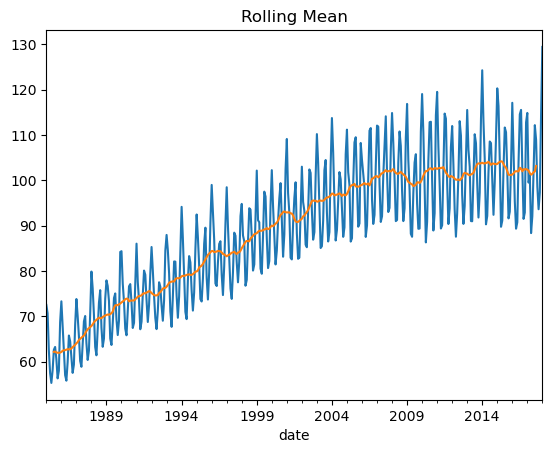

In [152]:
df_data["value"].plot()
df_data["value"].rolling(12,center=True).mean().plot()
plt.title("Rolling Mean")

Dal correlogramma possiamo notare che la serie presenta un andamento decrescente all'aumentare dei lag e delle autocorrelazioni alte fisse che si ripetono.  
Da ciò possiamo dedurre che la serie abbia una tendenza e una stagionalità

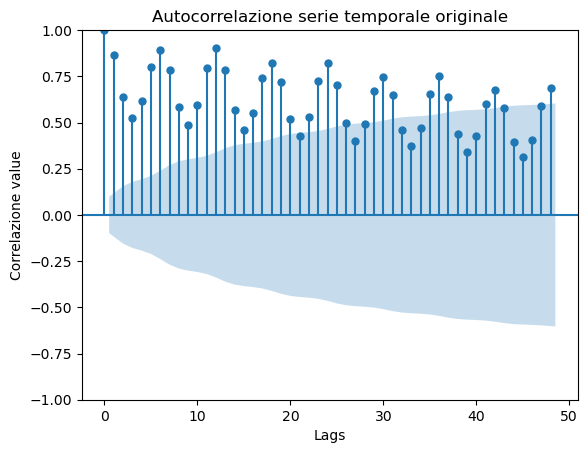

In [153]:
plot_acf(df["value"],lags=48)
plt.title("Autocorrelazione serie temporale originale")
plt.ylabel("Correlazione value")
plt.xlabel("Lags")
plt.show()

Dalla 

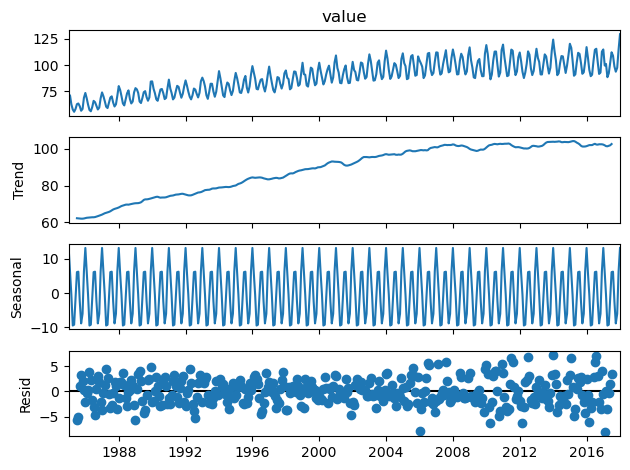

In [154]:
decomposition_additive = seasonal_decompose(df["value"],model='additive')
decomposition_additive.plot()
plt.show()

# Modello di regressione standard
Aggiungiamo delle colonne al nostro dataset originale per indicare meglio l'informazione temporale e la stagione in cui si trova l'esempio.

In [155]:
# Creiamo una variabile che indichi il numero del mese (eliminando la prima variabile dummy per evitare problemi di collinearità)
df['month_no']=df['date'].dt.month
month_vars=pd.get_dummies(df['month_no'], drop_first=True,prefix='m').astype(int)

# concateniamo le colonne dummy al dataset originale
df_regr = pd.concat([df,month_vars], axis=1)

# Aggiungiamo la variabile tempo che considera il numero di giorni dalla prima osservazione
df_regr['time']=df_regr['date'].diff().dt.days.fillna(0).cumsum()

df_regr.head()

,date,value,month_no,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,time
1985-01-01,1985-01-01,72.5052,1,0,0,0,0,0,0,0,0,0,0,0,0.0
1985-02-01,1985-02-01,70.6720,2,1,0,0,0,0,0,0,0,0,0,0,31.0
1985-03-01,1985-03-01,62.4502,3,0,1,0,0,0,0,0,0,0,0,0,59.0
1985-04-01,1985-04-01,57.4714,4,0,0,1,0,0,0,0,0,0,0,0,90.0
1985-05-01,1985-05-01,55.3151,5,0,0,0,1,0,0,0,0,0,0,0,120.0


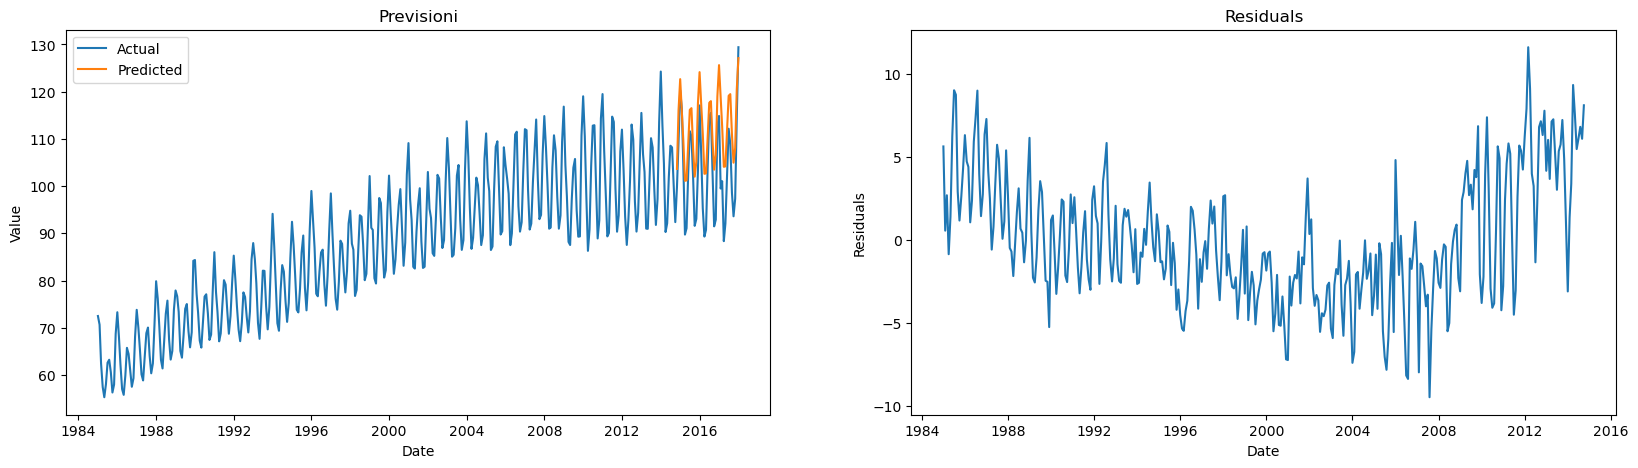

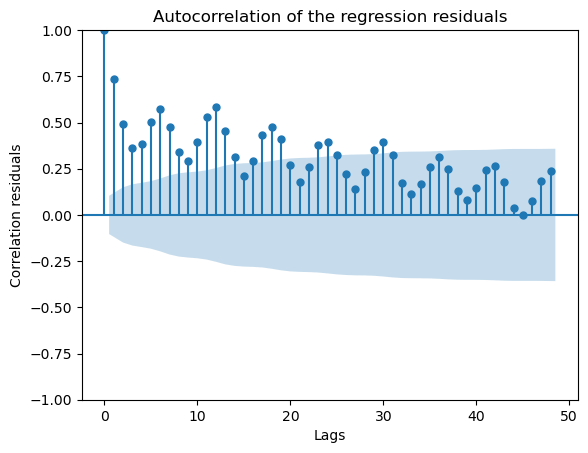

In [156]:
# Indichiamo la dimensione del test set
test_set_size = int(df.shape[0]*0.10)

# Creiamo il train e test set
Y_train = df_regr['value'].iloc[:-test_set_size]
X_train = df_regr[['time', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']].iloc[:-test_set_size]
X_train = sm.add_constant(X_train)

Y_test = df_regr['value'].iloc[-test_set_size:]
X_test = df_regr[['time', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']].iloc[-test_set_size:]
X_test = sm.add_constant(X_test)

# Creiamo il modello di regressione
model = sm.OLS(Y_train,X_train)
results = model.fit()

# Prendiamo le previsioni
predictions = results.predict(X_test)

fig, ax = plt.subplots(1,2,figsize=(20, 5))

# Plot delle previsioni
ax[0].plot(df['date'], df['value'])
ax[0].plot(df['date'].iloc[-test_set_size:], predictions)
ax[0].set_title('Previsioni')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Value')
ax[0].legend(['Actual', 'Predicted'])

# Plot dei residui
residuals=(results.predict(X_train) - Y_train)
ax[1].plot(residuals)
ax[1].set_title('Residuals')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Residuals')

# Correlogramma dei residui
plot_acf(results.resid,lags=48)
plt.ylabel('Correlation residuals')
plt.xlabel('Lags')
plt.title('Autocorrelation of the regression residuals')
plt.show()

# Rendiamo la serie stazionaria

Text(0.5, 0, 'Lags')

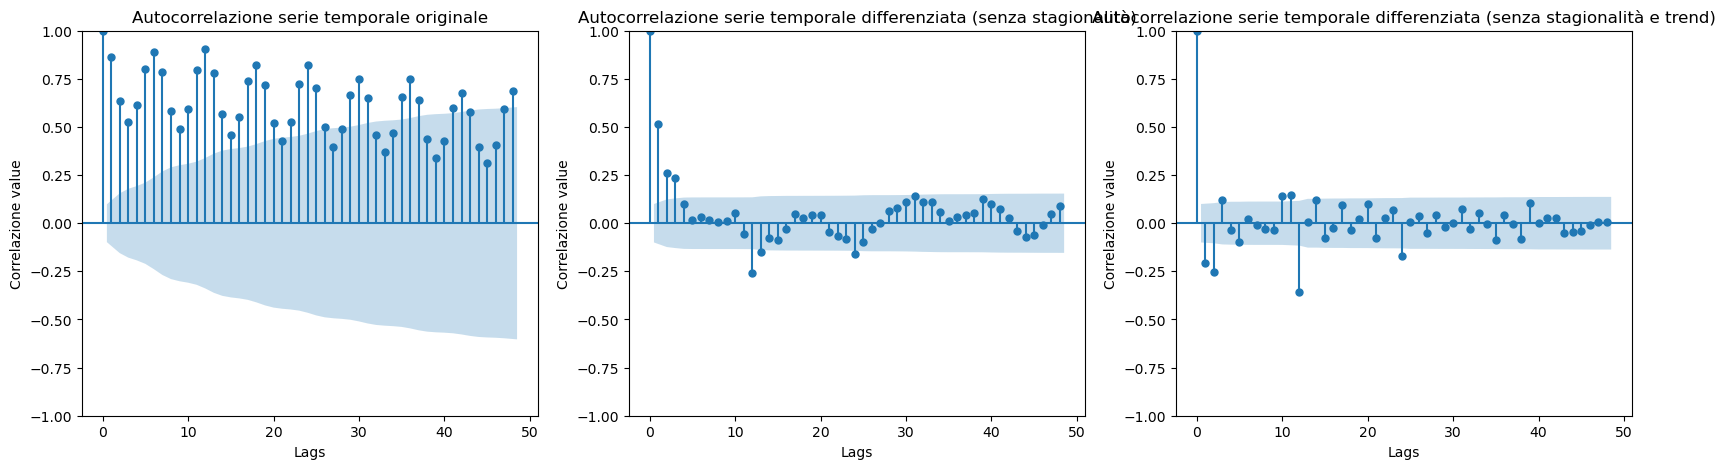

In [176]:
fig, ax = plt.subplots(1,3,figsize=(20, 5))

plot_acf(df["value"],lags=48,ax=ax[0])
ax[0].set_title("Autocorrelazione serie temporale originale")
ax[0].set_ylabel("Correlazione value")
ax[0].set_xlabel("Lags")

plot_acf(df["value"].diff(12).dropna(),lags=48,ax=ax[1])
ax[1].set_title("Autocorrelazione serie temporale differenziata (senza stagionalità)")
ax[1].set_ylabel("Correlazione value")
ax[1].set_xlabel("Lags")

plot_acf(df["value"].diff(12).diff(1).dropna(),lags=48,ax=ax[2])
ax[2].set_title("Autocorrelazione serie temporale differenziata (senza stagionalità e trend)")
ax[2].set_ylabel("Correlazione value")
ax[2].set_xlabel("Lags")

Statistica del test ADF: -8.022039209985007
P-value: 2.0639252090771793e-12
Critical Values:
	1%: -3.45
	5%: -2.87
	10%: -2.57
La serie è stazionaria


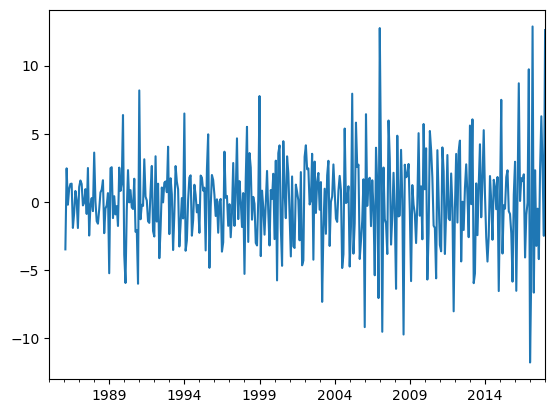

In [157]:
df["diff"] = df["value"].diff(12).diff(1)
df["diff"].plot()
test_ADF(df["diff"].dropna())

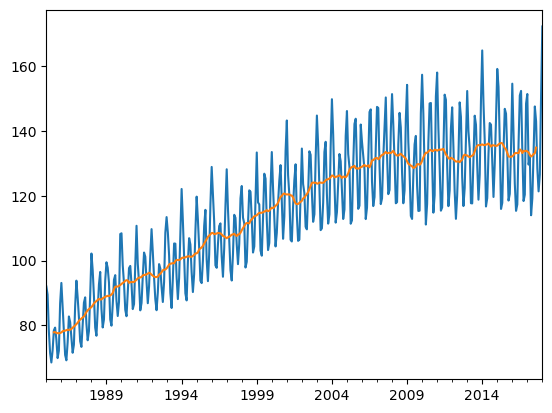

In [158]:
df["boxcox"], lmbda = boxcox(df["value"])
df["boxcox"].plot()
df["boxcox"].rolling(12,center=True).mean().plot()
plt.show()

Text(0.5, 0, 'Lags')

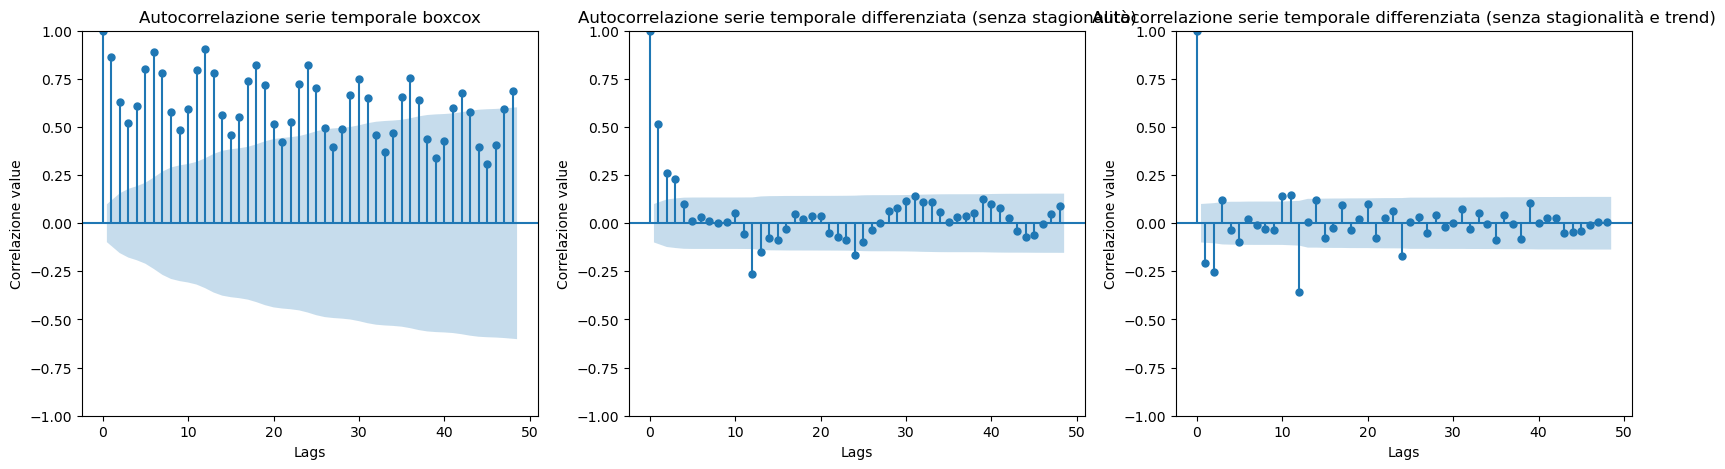

In [177]:
fig, ax = plt.subplots(1,3,figsize=(20, 5))

plot_acf(df["boxcox"],lags=48,ax=ax[0])
ax[0].set_title("Autocorrelazione serie temporale boxcox")
ax[0].set_ylabel("Correlazione value")
ax[0].set_xlabel("Lags")

plot_acf(df["boxcox"].diff(12).dropna(),lags=48,ax=ax[1])
ax[1].set_title("Autocorrelazione serie temporale differenziata (senza stagionalità)")
ax[1].set_ylabel("Correlazione value")
ax[1].set_xlabel("Lags")

plot_acf(df["boxcox"].diff(12).diff(1).dropna(),lags=48,ax=ax[2])
ax[2].set_title("Autocorrelazione serie temporale differenziata (senza stagionalità e trend)")
ax[2].set_ylabel("Correlazione value")
ax[2].set_xlabel("Lags")


Statistica del test ADF: -8.019032731600417
P-value: 2.100542808733394e-12
Critical Values:
	1%: -3.45
	5%: -2.87
	10%: -2.57
La serie è stazionaria


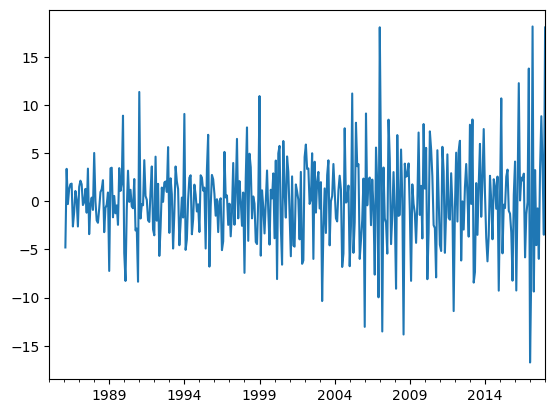

In [178]:
df["diff_boxcox"] = df["boxcox"].diff(12).diff(1)
df["diff_boxcox"].plot()
test_ADF(df["diff_boxcox"].dropna())

# Modello Autoregressivo

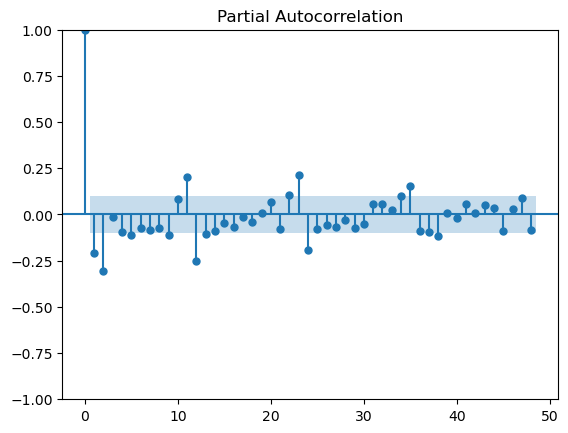

In [161]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['diff'].dropna(),lags=48)
plt.show()

In [162]:
# Split train and test
train = df.iloc[:-test_set_size]
test = df.iloc[-test_set_size:]

# Build AR model
selector = ar_select_order(train['diff'].dropna(), 15, seasonal=True, period=12)
model = AutoReg(train['diff'].dropna(), lags=selector.ar_lags, seasonal=True, period=12).fit()

/var/folders/x5/xvsgcbj13_s9tdm6w_4zqg9m0000gn/T/ipykernel_47372/336218406.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['forecasts']= list(model.forecast(steps=len(test)))


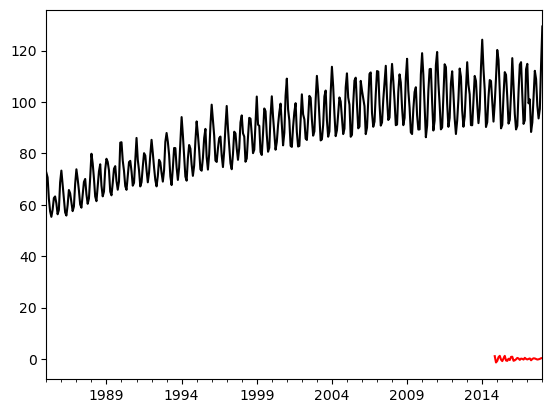

In [180]:
test['forecasts']= list(model.forecast(steps=len(test)))


df['value'].plot(color='k')
test['forecasts'].plot(color='red')
plt.show()


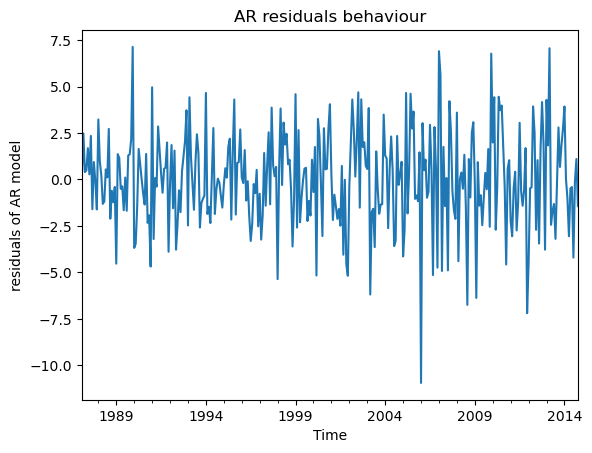

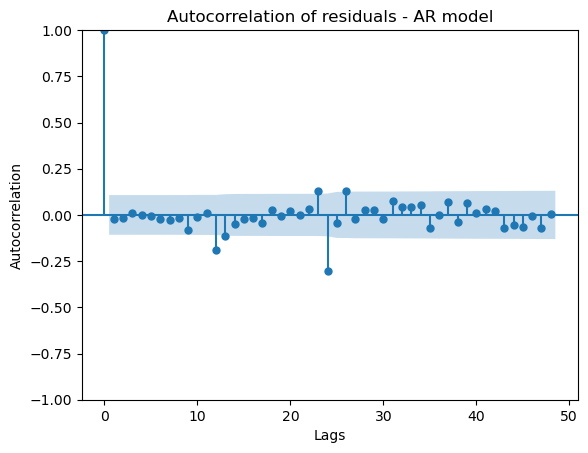


      lb_stat  lb_pvalue
1    0.157190   0.691757
2    0.273605   0.872142
3    0.301789   0.959692
4    0.302579   0.989647
5    0.325680   0.997132
6    0.487308   0.997990
7    0.771489   0.997724
8    0.858438   0.998994
9    3.006859   0.964022
10   3.066183   0.979823
11   3.113601   0.989138
12  15.579723   0.211252
13  20.051597   0.093931
14  20.844655   0.105680
15  21.017760   0.136263


In [164]:
residuals=(train['diff'] - model.fittedvalues).dropna()
residuals.plot()
plt.ylabel('residuals of AR model')
plt.xlabel('Time')
plt.title('AR residuals behaviour')
plt.show()

plot_acf(residuals,lags=48)
plt.ylabel('Autocorrelation')
plt.xlabel('Lags')
plt.title('Autocorrelation of residuals - AR model')
plt.show()
print()
# Carry out Ljung-Box test
print(acorr_ljungbox(residuals, lags =15, return_df=True))